# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Загрузка данных

Импортируем библиотеки, которые нам понадобятся для дальнейшей работы:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


import warnings
warnings.filterwarnings('ignore')

Откроем наш датасет. Выведем на экран первые пять объектов, общую информацию о датасете и список характерных значений.

In [2]:
df = pd.read_csv('/datasets/autos.csv')
pd.options.display.max_columns = None

display(df.head())
print('--------------------------------------------------')
df.info()
print('--------------------------------------------------')
df.describe()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen         

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Согласно документации к данным:

**Признаки**
- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `NotRepaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

**Целевой признак**
- `Price` — цена (евро)

В результате первоначального ознакомления с датасетом, мы можем отметить, что датасет состоит из 354369 объектов и 16 признаков. Столбец `Price` будет являться целевым признаком. Т. к. признак количесвтенный, то будет решаться задача регрессии. 

Далее проведем предобработку данных. 

### Предобработка данных

Для начала проверим наши данные на дубликаты:

In [3]:
df.duplicated().sum()

4

Обнаружено 4 дубликата. Удалим их. 

In [4]:
df = df.drop_duplicates().reset_index(drop=True)

Далее удалим столбцы (признаки), которые не будут влиять на прогнозирование стоимости автомобиля.

In [5]:
df = df.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis = 1)

Следующим шагом проверим наш датасет на пропуски

In [6]:
df.isna().sum()

Price                   0
VehicleType         37490
RegistrationYear        0
Gearbox             19833
Power                   0
Model               19705
Kilometer               0
FuelType            32895
Brand                   0
NotRepaired         71154
dtype: int64

Удалим из датасета строки, где встречаются 3 и более NaN, тк такие данные будет сложно восстановить. 

In [7]:
df = df.dropna(subset=['VehicleType', 'Gearbox', 'Model', 'FuelType'], thresh=3, axis=0)

In [8]:
df.isna().sum()

Price                   0
VehicleType         15102
RegistrationYear        0
Gearbox              7125
Power                   0
Model                9439
Kilometer               0
FuelType            11132
Brand                   0
NotRepaired         55104
dtype: int64

Пропусков стало заметно меньше.

Далее пройдёмся по каждому признаку и подготовим к дальнейшей работе

**Price**

В данном столбце пропусков нет. Тип данных корректен. Проверим на выбросы. 

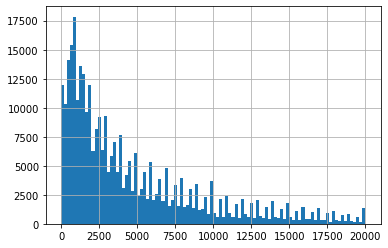

In [9]:
df['Price'].hist(bins=100)
plt.show()

Видим, что что присутствуют аномальные выбросы со значением 0. Также стоит отметить, что присутсвуют значения с низкой ценой, что не может соответсовать корректной цене автомобиля. Примем нижнюю границы корректной цены за 100. Предположим, что за такую цену выставляют самые "плохие" варианты. 

In [10]:
len(df[df['Price'] <= 100])   #количество строк со значением 0 в стролбце Price

9526

Т.к. данный признак является целевым, удалим данные выбросы. 

In [11]:
df = df.loc[df['Price'] > 100]

**VehicleType**

Для восстановления пропусков в столбцe, мы можем восстановить данные по моде, сгруппировав `Model` и `Brand`. Но в столбце `Model` присутсвуют пропуски, что не даст нам выполнить данное действие. Пропуски в моделе машины составляют всего 3 % от всего датасета, поэтому следующим действием мы их удалим, а далее уже восстановим пропуски в `VehicleType`.

In [12]:
df = df[df['Model'].isna() == False]

In [13]:
df['VehicleType'] = df['VehicleType'].fillna(df.groupby(['Model', 'Brand'])['VehicleType'].transform(lambda x: x.mode()[0] if not x.mode().empty else np.nan))

**RegistrationYear**

В данном столбце пропусков нет. Тип данных корректен. Проверим на выбросы. 

In [14]:
df['RegistrationYear'].value_counts(bins=30)

(2000.0, 2166.667]      202812
(1833.333, 2000.0]      105813
(4833.333, 5000.0]           5
(994.999, 1166.667]          1
(3666.667, 3833.333]         1
(2833.333, 3000.0]           1
(5833.333, 6000.0]           1
(1333.333, 1500.0]           1
(1500.0, 1666.667]           1
(2166.667, 2333.333]         0
(4166.667, 4333.333]         0
(5666.667, 5833.333]         0
(5500.0, 5666.667]           0
(5333.333, 5500.0]           0
(5166.667, 5333.333]         0
(5000.0, 5166.667]           0
(4666.667, 4833.333]         0
(4500.0, 4666.667]           0
(4333.333, 4500.0]           0
(4000.0, 4166.667]           0
(2333.333, 2500.0]           0
(3833.333, 4000.0]           0
(1166.667, 1333.333]         0
(3333.333, 3500.0]           0
(3166.667, 3333.333]         0
(3000.0, 3166.667]           0
(1666.667, 1833.333]         0
(2666.667, 2833.333]         0
(2500.0, 2666.667]           0
(3500.0, 3666.667]           0
Name: RegistrationYear, dtype: int64

Видим выбросы. Для нижней границы, если год регистрации автомобиля меньше 1916г. Для верхней границы возьмём 2020г.

In [15]:
df = df.loc[df['RegistrationYear'] < 2016]
df = df.loc[df['RegistrationYear'] > 1970]

**Gearbox**

Заменим пропуски аналогично как мы это делали с типом кузова. Также изменим тип данных на булевой.

In [16]:
df['Gearbox'].value_counts()

manual    231362
auto       58825
Name: Gearbox, dtype: int64

In [17]:
df['Gearbox'] = df['Gearbox'].fillna(df.groupby(['Model', 'Brand'])['Gearbox'].transform(lambda x: x.mode()[0] if not x.mode().empty else np.nan))

In [18]:
df['Gearbox'] = df['Gearbox'].map({'auto':1, 'manual':0}).astype(int)

**Power**

В данном столбце пропусков нет. Тип данных корректен. Проверим на выбросы.

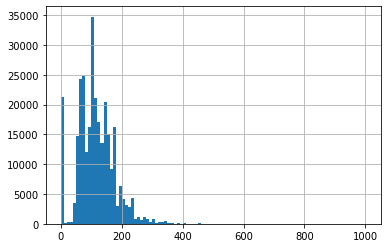

In [19]:
df['Power'].hist(bins=100, range=(0, 1000))
plt.show()

По гистограмме установим верхнюю границу в 450. Также мощность меньше 50 будем считать выбросами. Удалим данные выбросы, тк размер выборки позволяет. 

In [20]:
df = df.loc[df['Power'] < 450]
df = df.loc[df['Power'] > 50]

Посмотри на оставшиеся пропуски в столбйе `Power`. 

In [22]:
df[df['Power'].isna() == True]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired


Всего лишь один пропуск. Его можно смело удалить!

In [23]:
df = df.dropna(axis='index', how='any', subset=['Power'])

**Model**

Пропусков в данном столбце нет. Мы это сделали чуть выше. Тип данных корректен. Посмотрим на возможные значения.

In [24]:
df['Model'].sort_values().unique()

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '6_reihe', '6er', '7er', '80', '850', '90', '900', '9000',
       '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8', 'a_klasse',
       'accord', 'agila', 'alhambra', 'almera', 'altea', 'amarok',
       'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo', 'aygo',
       'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora', 'boxster',
       'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse', 'c_max',
       'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma', 'carnival',
       'cayenne', 'cc', 'ceed', 'charade', 'cherokee', 'citigo', 'civic',
       'cl', 'clio', 'clk', 'clubman', 'colt', 'combo', 'cooper',
       'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma', 'crossfire',
       'cuore', 'cx_reihe', 'defender', 'delta', 'discovery', 'doblo',
       'ducato', 'duster', 'e_klasse', 'elefantino', 'eos', 'escort',
       'espace', 'ex

С данным признаком всё в порядке

**Kilometer**

В данном столбце пропусков нет. Тип данных корректен. Проверим на выбросы.

In [25]:
df['Kilometer'].value_counts(bins=10).sort_index()

(4854.999, 19500.0]       2753
(19500.0, 34000.0]        6528
(34000.0, 48500.0]        4206
(48500.0, 63000.0]       11664
(63000.0, 77500.0]        7236
(77500.0, 92000.0]       17833
(92000.0, 106500.0]      11632
(106500.0, 121000.0]         0
(121000.0, 135500.0]     28957
(135500.0, 150000.0]    176249
Name: Kilometer, dtype: int64

По пробегу данные выглядят в порядке.

**FuelType**

Восстановим пропуски в `FuelType` аналогично как мы это делали с `VehicleType` и `Gearbox`. 

In [26]:
df['FuelType'] = df['FuelType'].fillna(df.groupby(['Model', 'Brand'])['FuelType'].transform(lambda x: x.mode()[0] if not x.mode().empty else np.nan))

Далее  посмотрим на возможные значения в данном столбце.

In [27]:
df['FuelType'].value_counts()

petrol      175984
gasoline     86036
lpg           4334
cng            456
hybrid         174
other           44
electric        30
Name: FuelType, dtype: int64

Стоит отметить, что `gasoline` и `petrol` по факту обозначают одно и тодже - бензин. Просто первый используется в американском английском, а второй - британском. Заменим значения `gasoline` на `petrol`. 

In [28]:
df['FuelType'] = df['FuelType'].replace('gasoline', 'petrol')

**Brand**

Пропусков в данном столбце нет. Мы это сделали чуть выше. Тип данных корректен. Посмотрим на возможные значения.

In [29]:
df['Brand'].sort_values().unique()

array(['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen',
       'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai',
       'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda',
       'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot',
       'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart',
       'subaru', 'suzuki', 'toyota', 'trabant', 'volkswagen', 'volvo'],
      dtype=object)

С данными всё в порядке.

**NotRepaired**

Прежде чем заменять пропуски, посмотрим какой процент они составляют от всего признака.

In [30]:
df['NotRepaired'].value_counts(dropna=False, normalize=True)

no     0.783332
NaN    0.124333
yes    0.092336
Name: NotRepaired, dtype: float64

Получилось, что ~ 16% пропусков. Мы не можем утверждать, что 16% человек просто забыли отметить ремонт автомобиля. Поэтому в данным случае отметим пропуски словом маркером `unknown`.

In [31]:
df['NotRepaired'] = df['NotRepaired'].fillna('unknown')

В результате данного пункта мы первично ознакомились с нашим датасетом. Сделали предобработку данных для дальнейшего обучения моделей: заполнили пропуски, проверили данные на выбросы и скорректировали их. Также проверили наши данные на дубликаты и удалили лишние признаки, которые не будут влиять на дальнейшее обучение моделей. 

## Обучение моделей

Далее расммотрим три модели:

- RandomForestRegressor
- LinearRegression
- LightGBM
- CatBoost

Но для начала надо подготовить наш датасет к обучению. 

### Кодирование, деление и стандартизация выборки

Как известно LightGBM и Catboost работают с категориальными признаками, а вот для LinearRegression требуется кодирование и стандартизация. 

Закодиурем наши категориальные признаки, используя Ohe-Hot Encoding (прямое кодирование).

In [32]:
df_ohe = pd.get_dummies(df, drop_first=True)

Далее выделим целевой признак и разделим наши выборки на обучающую и тестовую в отношении 3:1.

In [33]:
target = df['Price']
features = df.drop(['Price'], axis=1)

target_ohe = df_ohe['Price']
features_ohe = df_ohe.drop(['Price'], axis=1)

features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                             target, 
                                                                             test_size=0.25, 
                                                                             random_state=12345)

features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = train_test_split(features_ohe, 
                                                                             target_ohe, 
                                                                             test_size=0.25, 
                                                                             random_state=12345)

Т.к. в данных присутствуют количественные признаки с разными разбросами значений, то следует привести эти признаки к одному масштабу. Один из методов масштабирования - стандартизация данных. Применем его.

In [34]:
numeric = ['RegistrationYear', 'Power', 'Kilometer']

scaler = StandardScaler()
scaler.fit(features_train_ohe[numeric])

features_train_ohe[numeric] = scaler.transform(features_train_ohe[numeric])
features_test_ohe[numeric] = scaler.transform(features_test_ohe[numeric])

pd.options.mode.chained_assignment = None

Далее можем приступать к обучению моделей

### Обучение моделей

**RandomForestRegressor**

In [35]:
model_ran_for_reg = RandomForestRegressor(random_state=12345)
parametrs_ran_for_reg = { 'max_depth': range (3, 8),
                          'n_estimators': range (1, 33, 8)}
grid_ran_for_reg = GridSearchCV(model_ran_for_reg, parametrs_ran_for_reg, cv=5)

In [36]:
%%time
grid_ran_for_reg.fit(features_train_ohe, target_train_ohe)

print ('best_params_' ,grid_ran_for_reg.best_params_)

best_params_ {'max_depth': 7, 'n_estimators': 25}
CPU times: user 21min 24s, sys: 24.3 s, total: 21min 48s
Wall time: 21min 50s


In [37]:
%%time
model_ran_for_reg = RandomForestRegressor(max_depth=7, n_estimators=25, random_state=12345)
model_ran_for_reg.fit(features_train_ohe, target_train_ohe)

CPU times: user 41.7 s, sys: 284 ms, total: 42 s
Wall time: 42 s


RandomForestRegressor(max_depth=7, n_estimators=25, random_state=12345)

**Linear Regression**

In [38]:
model_lin_reg = LinearRegression()

In [39]:
%%time

model_lin_reg.fit(features_train_ohe, target_train_ohe)

CPU times: user 13.7 s, sys: 3.52 s, total: 17.2 s
Wall time: 17.2 s


LinearRegression()

**LightGBM**

In [40]:
category = ['VehicleType', 'Model', 'FuelType', 'Brand', 'NotRepaired']

In [41]:
features_train[category] = features_train[category].astype('category')
features_test[category] = features_test[category].astype('category')

In [42]:
model_lightGBM = LGBMRegressor(random_state=12345)
parametrs_lightGBM = { 'max_depth': range (5, 9),
                       'n_estimators': range (10, 40, 10)}
grid_lightGBM = GridSearchCV(model_lightGBM, parametrs_lightGBM, cv=5)

In [43]:
%%time

grid_lightGBM.fit(features_train, target_train)

print ('best_params_' ,grid_lightGBM.best_params_)

best_params_ {'max_depth': 8, 'n_estimators': 30}
CPU times: user 13min 47s, sys: 6.17 s, total: 13min 53s
Wall time: 14min 1s


In [44]:
%%time

model_lightGBM = LGBMRegressor(random_state=12345, max_depth=8, n_estimators=30)
model_lightGBM.fit(features_train, target_train)

CPU times: user 1.76 s, sys: 7.55 ms, total: 1.77 s
Wall time: 1.8 s


LGBMRegressor(max_depth=8, n_estimators=30, random_state=12345)

**CatBoost**

In [45]:
model_catboost = CatBoostRegressor(random_state=12345)
parametrs_catboost = { 'max_depth': range (5, 9),
                       'n_estimators': range (10, 40, 10)}
grid_catboost = GridSearchCV(model_catboost, parametrs_catboost, cv=5)

In [46]:
%%time

grid_catboost.fit(features_train, target_train, cat_features=category, verbose=False)

print ('best_params_' ,grid_catboost.best_params_)

best_params_ {'max_depth': 8, 'n_estimators': 30}
CPU times: user 1min 22s, sys: 738 ms, total: 1min 23s
Wall time: 1min 32s


In [47]:
%%time

model_catboost = CatBoostRegressor(max_depth=8, n_estimators=30, random_state=12345)
model_catboost.fit(features_train, target_train, cat_features=category, verbose=False)

CPU times: user 2.74 s, sys: 47.8 ms, total: 2.78 s
Wall time: 2.96 s


**Вывод:**

В резульате обучения модели мы можем сделать вывод о скрости обучения раличных моделей: модели LightGBM и CatBoost обучались быстрее всего - 1.8 с и 2.96 с соответственно. А вот модели RandomForestRegressor и LinearRegression обучаются дольше - 42 c и 17.2 с. Также стоит отметить, что понадобилось достаточно большое количество время для подбора гиперпараметров для моделей RandomForestRegressor и LightGBM. Для первой понадобилось 21 мин 50 с, а для второй 14 мин 1 с. 

Далее посмотрим на качество наших моделей.

## Анализ моделей

**RandomForestRegressor**

In [48]:
%%time

predictions_ran_for_reg = model_ran_for_reg.predict(features_test_ohe)
print('RMSE линейной регресси:', mean_squared_error(target_test_ohe, predictions_ran_for_reg)**0.5)

RMSE линейной регресси: 2079.4472388134323
CPU times: user 124 ms, sys: 69.4 ms, total: 193 ms
Wall time: 191 ms


**LinearRegression**

In [49]:
%%time

predictions_lin_reg = model_lin_reg.predict(features_test_ohe)
print('RMSE линейной регресси:', mean_squared_error(target_test_ohe, predictions_lin_reg)**0.5)

RMSE линейной регресси: 2428.458955339948
CPU times: user 91.7 ms, sys: 57.4 ms, total: 149 ms
Wall time: 135 ms


**LightGBM** 

In [50]:
%%time

predictions_lightGBM = model_lightGBM.predict(features_test)
print('RMSE LightGBM:', mean_squared_error(target_test, predictions_lightGBM)**0.5)

RMSE LightGBM: 1708.597523581691
CPU times: user 218 ms, sys: 12.4 ms, total: 231 ms
Wall time: 296 ms


**CatBoost**

In [51]:
%%time

predictions_catboost = model_catboost.predict(features_test)
print('RMSE CatBoost:', mean_squared_error(target_test, predictions_catboost)**0.5)

RMSE CatBoost: 1645.8033018961105
CPU times: user 32.2 ms, sys: 8.09 ms, total: 40.3 ms
Wall time: 38.5 ms


## Вывод

Сведём полученные данные о скорости обучения и качестве прогнозирования моделей в таблицу:


| Модель               | Скорость обучения | RMSE      |
| ------------------   | ------------------|-----------|
| RandomForestRegressor| 42 сек            | 2079.45   |
| LinearRegression     | 17.2 сек          | 2428.46   |
| LightGBM             | 1.8 сек           | 1708.60   |
| CatBoost             | 2.96 сек          | 1645.80   |

Таким образом, можно сделать вывод, что модели градиентного бустинга показали хорошие результаты, как по скрости обучения, так и по качеству модели. Но стоит учесть в данном случае, что для модели LightGBM требуется достаточно много времени для подбора оптимальных гиперпараметров. Что касается моделей RandomForestRegressor и LinearRegressor, то они и дольше обучаются и качество ниже. Для данного датасета оптимальнее всего будет модель CatBoost, тк важно качество расчёта стоимости автомобиля. 